# Notebook to correct images from dark and white

In [1]:
import sys
sys.path.append('../')

In [2]:
from src.exposure.normalisation import normalize_dark_white
from src.filters.cosmics import remove_cosmic
from src.io.imread import mmread
from src.io.imwrite import write_mmformat
from src.io.metadata import get_roi, make_global_metadata

import matplotlib.pyplot as plt
import stackview

## Load white stack

In [3]:
white_root_path = '../Examples/20220467_test_mosaic_dark_white/white_40x_100ms_1/'
white_metadata = make_global_metadata(white_root_path)
white = mmread(white_root_path).squeeze()
white

dask.array<getitem, shape=(101, 1024, 1024), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [4]:
stackview.slice(white[:, ::2, ::2], continuous_update=True)

## Load dark of white

Use the remove_cosmics modifiers to apply a filter on image loading

In [5]:
dark_of_white = mmread('../Examples/20220467_test_mosaic_dark_white/dark_of_white_40x_100ms_1/', modifiers=(remove_cosmic, )).squeeze()
dark_of_white

dask.array<getitem, shape=(512, 512), dtype=uint16, chunksize=(512, 512), chunktype=numpy.ndarray>

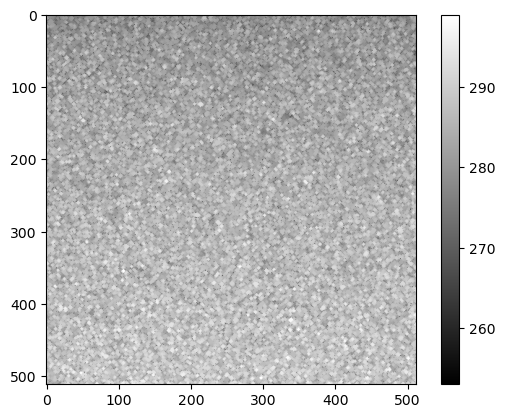

In [6]:
plt.imshow(dark_of_white, 'gray')
plt.colorbar()

## Load image stack

In [7]:
img_root_path = '../Examples/20220467_test_mosaic_dark_white/Est_map_40x_2/'
img_stack_metadata = make_global_metadata(img_root_path)
img_stack = mmread(img_root_path)
img_stack

dask.array<stack, shape=(42, 1, 6, 1, 512, 512), dtype=uint16, chunksize=(1, 1, 1, 1, 512, 512), chunktype=numpy.ndarray>

In [8]:
# View the second filter for all positions
stackview.picker(img_stack[:,0,1,0], continuous_update=True)

## Load the darks for this image stack

In [9]:
dark_stack = mmread('../Examples/20220467_test_mosaic_dark_white/dark_40x_5filters_no_crop_1/', modifiers=(remove_cosmic, ) )
dark_stack

dask.array<stack, shape=(1, 1, 6, 1, 1024, 1024), dtype=uint16, chunksize=(1, 1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

In [10]:
stackview.slice(dark_stack[0,0,:,0, ::2, ::2], continuous_update=True)

## Normalize the image stack

In [11]:
# Need to get the roi of image stack to apply this roi to all other images
roi = get_roi(img_stack_metadata)
print(f'Roi {roi}')
xstart = roi[0]
xstop = xstart + roi[2]
ystart = roi[1]
ystop = ystart + roi[3]

# Do I need to crop the dark_stack
if dark_stack.shape[-2] > roi[2] or dark_stack.shape[-1] > roi[1]:
    dark_stack_crop = dark_stack[..., ystart:ystop, xstart:xstop]
else:
    dark_stack_crop = dark_stack
    
# Do I need to crop the white 
if white.shape[-2] > roi[2] or white.shape[-1] > roi[1]:
    white_crop = white[..., ystart:ystop, xstart:xstop]
else:
    white_crop = white
    
# Need to check if the dark_of_white as the same size of the white
roi_white = get_roi(white_metadata)
if dark_of_white.shape[-2] > roi_white[2] or dark_of_white.shape[-1] > roi_white[1]:
    dark_of_white_crop = dark_of_white[roi_white[1]:roi_white[1]+roi_white[3], roi_white[0]:roi_white[0]+roi_white[2]]
else:
    dark_of_white_crop = dark_of_white
    
normalized_imgs = normalize_dark_white(img_stack, dark_stack_crop, white_crop[int(len(white_crop)/2)], dark_of_white_crop)

Roi [256, 256, 512, 512]


In [12]:
stackview.curtain(normalized_imgs[:,0,1,0], img_stack[:,0,1,0], continuous_update=True)

## Export the new corrected data as a MicroManager like file format

In [14]:
write_mmformat(img_root_path, './corrected_white', img_stack_metadata, normalized_imgs)

[########################################] | 100% Completed |  2.1s
